# Imports

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision import models,transforms,datasets
import torch
import bcolz
import time
%matplotlib inline

In [2]:
import imp
import utils; imp.reload(utils)
from utils import *

In [3]:
use_gpu =  False

GPU test

In [4]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

Using gpu: True 


In [5]:
a = torch.tensor(2)
a.cuda()

tensor(2, device='cuda:0')

# Data process

In [4]:
# data_dir = 'D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_Food101\\images'
data_dir = 'D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_2\\'

In [5]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), prep1)
         for x in ['train', 'test']}

In [6]:
len(dsets['train'].classes)

2

In [7]:
dsets['train'].class_to_idx

{'apple_pie': 0, 'baby_back_ribs': 1}

In [10]:
dsets['train'].imgs[:5]

[('D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_10\\train\\apple_pie\\apple_pie_0.jpg',
  0),
 ('D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_10\\train\\apple_pie\\apple_pie_100.jpg',
  0),
 ('D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_10\\train\\apple_pie\\apple_pie_101.jpg',
  0),
 ('D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_10\\train\\apple_pie\\apple_pie_102.jpg',
  0),
 ('D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_10\\train\\apple_pie\\apple_pie_104.jpg',
  0)]

In [22]:
dset_classes = dsets['train'].classes

In [24]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'test']}
dset_sizes

{'train': 1363, 'test': 455}

Dataset loaders

In [8]:
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=64,
                                               shuffle=shuffle_valtrain(x), num_workers=0)
                for x in ['train', 'test']}

In [42]:
dataset_valid = torch.utils.data.DataLoader(dsets['test'], batch_size=5, shuffle=True, num_workers=0)

In [14]:
len(dataset_valid)

449

In [15]:
count = 0
for data in dataset_valid:
    if count == 0:
        inputs_try,labels_try = data
    else:
        break
    count += 1

In [16]:
labels_try

tensor([3, 3, 4, 8, 9])

In [17]:
inputs_try.shape

torch.Size([5, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


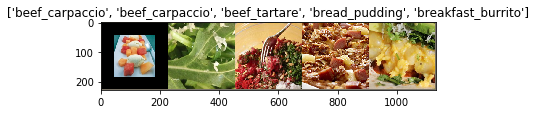

In [18]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


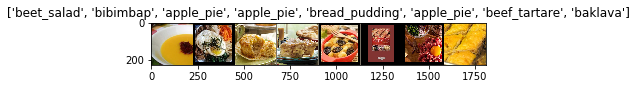

In [19]:
# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


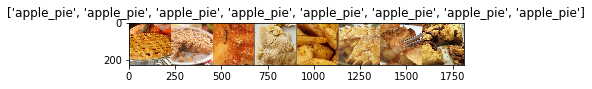

In [20]:
# Get a batch of validation data
inputs, classes = next(iter(dset_loaders['test']))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

# Creating VGG Model

In [9]:
model_vgg = models.vgg16(pretrained=True)

In [10]:
inputs_try , labels_try = var_cgpu(inputs_try,use_gpu),var_cgpu(labels_try,use_gpu)

if use_gpu:
    model_vgg = model_vgg.cuda()

NameError: name 'inputs_try' is not defined

In [23]:
outputs_try = model_vgg(inputs_try)

In [ ]:
outputs_try

In [ ]:
outputs_try.shape

### Modifying the last layer and setting the gradient false to all layers

In [11]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [12]:
for param in model_vgg.parameters():
    param.requires_grad = False
model_vgg.classifier._modules['6'] = nn.Linear(4096, 2)

In [13]:
print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


In [28]:
if use_gpu:
    model_vgg = model_vgg.cuda()

## Calculating preconvoluted features

In [14]:
def preconvfeat(dataset):
    conv_features = []
    labels_list = []
    count = 0
    for data in dataset:
        print(count)
        count += 1
        inputs,labels = data
        if use_gpu:
            inputs , labels = Variable(inputs.cuda()),Variable(labels.cuda())
        else:
            inputs , labels = Variable(inputs),Variable(labels)
        
        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [15]:
%%time
conv_feat_train,labels_train = preconvfeat(dset_loaders['train'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
Wall time: 21min 12s


In [17]:
%%time
conv_feat_val,labels_val = preconvfeat(dset_loaders['test'])

0
1
2
3
4
5
6
7
Wall time: 5min 11s


### Save extracted features

In [30]:
save_array(data_dir+'\\vgg16\\conv_feat_train.bc',conv_feat_train)
save_array(data_dir+'\\vgg16\\labels_train.bc',labels_train)
save_array(data_dir+'\\vgg16\\conv_feat_val.bc',conv_feat_val)
save_array(data_dir+'\\vgg16\\labels_val.bc',labels_val)

### Load extracted features

In [ ]:
conv_feat_train = load_array(data_dir+'\\vgg16\\conv_feat_train.bc')
labels_train = load_array(data_dir+'\\vgg16\\labels_train.bc')
conv_feat_val = load_array(data_dir+'\\vgg16\\conv_feat_val.bc')
labels_val = load_array(data_dir+'\\vgg16\\labels_val.bc')

## Training fully connected module

### Creating loss function and optimizer

In [18]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)

### Creating Data generator

In [19]:
def data_gen(conv_feat,labels,batch_size=64,shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(conv_feat))
        conv_feat = conv_feat[index]
        labels = labels[index]
    for idx in range(0,len(conv_feat),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])

### Training the model

In [20]:
def train_model(model,size,conv_feat=None,labels=None,epochs=1,optimizer=None,train=True,shuffle=True):
    if train:
        model.train()
    else:
        model.eval()
        
    for epoch in range(epochs):
        batches = data_gen(conv_feat=conv_feat,labels=labels,shuffle=shuffle)
        total = 0
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in batches:
            if use_gpu:
                inputs , classes = torch.from_numpy(inputs).cuda(), torch.from_numpy(classes).cuda()
            else:
                inputs , classes = torch.from_numpy(inputs), torch.from_numpy(classes)
                
            inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            loss = criterion(outputs,classes)           
            if train:
                if optimizer is None:
                    raise ValueError('Pass optimizer for train mode')
                optimizer = optimizer
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
    

In [25]:
%%time
(train_model(model=model_vgg.classifier,size=dset_sizes['train'],conv_feat=conv_feat_train,labels=labels_train,
            epochs=10,optimizer=optimizer_vgg,train=True,shuffle=True))

Loss: 0.0060 Acc: 0.8217
Loss: 0.0041 Acc: 0.8819
Loss: 0.0035 Acc: 0.9061
Loss: 0.0032 Acc: 0.9259
Loss: 0.0034 Acc: 0.9215
Loss: 0.0029 Acc: 0.9259
Loss: 0.0031 Acc: 0.9193
Loss: 0.0031 Acc: 0.9274
Loss: 0.0029 Acc: 0.9274
Loss: 0.0028 Acc: 0.9376
Wall time: 32.5 s


In [28]:
train_model(conv_feat=conv_feat_val,labels=labels_val,model=model_vgg.classifier
            ,size=dset_sizes['test'],train=False,shuffle=False)

Loss: 0.0035 Acc: 0.9253


### Visualize some wrong images

In [50]:
m_softm = nn.Softmax(dim=1)

In [76]:
count = 0
for i in range(dset_sizes['test']):
    feat_val = torch.from_numpy(conv_feat_val[i]).view(1,-1)
    label_val = labels_val[i]
    
    _,pred = torch.max(m_softm(model_vgg.classifier(feat_val).data),1)
    
    predicted = pred.data.cpu().numpy()[0]
    
    if predicted != label_val:
        print(dsets['test'].imgs[i])
        count += 1
    #if count == 20:
    #    break

('D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_2\\test\\apple_pie\\apple_pie_103.jpg', 0)
('D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_2\\test\\apple_pie\\apple_pie_183.jpg', 0)
('D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_2\\test\\apple_pie\\apple_pie_302.jpg', 0)
('D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_2\\test\\apple_pie\\apple_pie_350.jpg', 0)
('D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_2\\test\\apple_pie\\apple_pie_512.jpg', 0)
('D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_2\\test\\apple_pie\\apple_pie_685.jpg', 0)
('D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_2\\test\\apple_pie\\apple_pie_756.jpg', 0)
('D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_2\\test\\apple_pie\\apple_pie_805.jpg', 0)
('D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_2\\test\\apple_pie\\apple_pie_833.jpg', 0)
('D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_2\\test\\apple_pie\\apple_pie_845.jpg', 0)
('D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_2\\test\\apple_pie\\apple_pie_914.jpg', 0)
('D:\\Tu B

In [57]:
feat_val = torch.from_numpy(conv_feat_val)

In [47]:
feat_val[0].view(-1)

tensor([0.0000, 2.7469, 1.1155,  ..., 0.0000, 0.0000, 0.0000])

In [65]:
_,pred = torch.max(m_softm(model_vgg.classifier(feat_val[0].view(1,-1)).data),1)

In [71]:
pred.data.cpu().numpy()[0]

0